In [26]:
###########################################################################
###########################################################################
###########################################################################
#===================== MODULES

import os, sys
import math
import numpy as np
import xarray as xr
from scipy.signal import argrelmax
import dask
import numpy as np

# plot
import cartopy.crs as ccrs
import cartopy.feature as ccf
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

# modules for detremnding
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy.interpolate as spi
def getspline(x,jd):
    smth=lowess(x,jd,25.0/55)
    fn=spi.UnivariateSpline(jd,smth[:,1],k=5,ext=0)
    return smth[:,1],fn

# read files

In [27]:
# READ
diri='/Users/leroux/DATA/OCCIPUT_DATA/AMOC/'


amocGSL   = xr.open_dataset(diri+'AMOCZ.MAX.NATL025-GSL301.1993-2012.1m.nc')['amocz']
amocTCLB  = xr.open_dataset(diri+'AMOCZ.MAX.NATL025-TCLB300.1994-2012.1m.nc')['amocz']


# detrend TCLB monhly 
(too big for CAL1?)

In [28]:
amoc = amocTCLB
jd = range(0,amoc.time_counter.size)
il=1
ie=1

for ie in range(0,10):
    
    for il in np.arange(0,amoc.nav_lat.size):  
        # timeseries with time-mean removed
        ts   = amoc.isel(nav_lat=il,e=ie).values
            
        # apply detrending
        ts_tr=getspline(ts,jd)[0]
        ts_dt = ts - ts_tr
     
        tmp = xr.DataArray(ts_dt, dims=('time_counter'),coords={'time_counter':amoc.time_counter})
        if (il!=0):
            concamoc = xr.concat([concamoc,tmp], dim='nav_lat')
        else:
            concamoc = tmp
    if (ie!=0):
        concconcamoc = xr.concat([concconcamoc,concamoc], dim='e')
    else:
        concconcamoc = concamoc
        
# make sure the time mean is exactly zero
concconcamoc = concconcamoc - concconcamoc.mean(dim='time_counter')

* write dt file

In [29]:
diro=diri
# change dims order so that it is the same as the non-detrended dataset
amoc_dt1 = concconcamoc.transpose('time_counter','e','nav_lat')

# redefine coordinate
amoc_dt1_def =  xr.DataArray(amoc_dt1.values, dims=('time_counter', 'e','nav_lat'),coords={'time_counter':amoc.time_counter,'e': amoc.e, 'nav_lat': amoc.nav_lat})

# output
outfi = diro+'AMOCZ.MAX.NATL025-TCLB300.1994-2012.1m_dt.nc'
amoc_dt1_def.name='amocz_dt'
amoc_dt1_def.attrs['long_name'] =  "detrended amoc z (lowess)"
amoc_dt1_def.to_netcdf(outfi,mode='w')

# detrend GSL monhly 
(oo big for CAL1?)

In [30]:
amoc = amocGSL
jd = range(0,amoc.time_counter.size)
il=1
ie=1

for ie in range(0,50):
    
    for il in np.arange(0,amoc.nav_lat.size):  
        # timeseries with time-mean removed
        ts   = amoc.isel(nav_lat=il,e=ie).values
            
        # apply detrending
        ts_tr=getspline(ts,jd)[0]
        ts_dt = ts - ts_tr
     
        tmp = xr.DataArray(ts_dt, dims=('time_counter'),coords={'time_counter':amoc.time_counter})
        if (il!=0):
            concamoc = xr.concat([concamoc,tmp], dim='nav_lat')
        else:
            concamoc = tmp
    if (ie!=0):
        concconcamoc = xr.concat([concconcamoc,concamoc], dim='e')
    else:
        concconcamoc = concamoc
        
# make sure the time mean is exactly zero
concconcamoc = concconcamoc - concconcamoc.mean(dim='time_counter')

* write dt file

In [31]:
diro=diri
# change dims order so that it is the same as the non-detrended dataset
amoc_dt1 = concconcamoc.transpose('time_counter','e','nav_lat')

# redefine coordinate
amoc_dt1_def =  xr.DataArray(amoc_dt1.values, dims=('time_counter', 'e','nav_lat'),coords={'time_counter':amoc.time_counter,'e': amoc.e, 'nav_lat': amoc.nav_lat})

# output
outfi = diro+'AMOCZ.MAX.NATL025-GSL301.1993-2012.1m_dt.nc'
amoc_dt1_def.name='amocz_dt'
amoc_dt1_def.attrs['long_name'] =  "detrended amoc z (lowess)"
amoc_dt1_def.to_netcdf(outfi,mode='w')

# read dt files as a check

In [58]:
## READ
amoc_dtREAD = xr.open_dataset(diro+'AMOCZ.MAX.NATL025-GSL301.1993-2012.1m_dt.nc')['amocz_dt']
amoc_dtREAD2 = xr.open_dataset(diro+'AMOCZ.MAX.NATL025-TCLB300.1994-2012.1m_dt.nc')['amocz_dt']


# Now remove annual cycle

In [59]:
# READ
amoc = amoc_dtREAD

# clim over 1 year
clim = amoc.groupby('time_counter.month').mean(dim='time_counter')

# rolling mean to smooth out the raw clim a little bit
#clim = clim.rolling(month=3,min_periods=1).mean()

# remove clim to data
amoc_acrm = amoc.groupby('time_counter.month')-clim

Text(0.5,1,'TCLB dt vs dtdc')

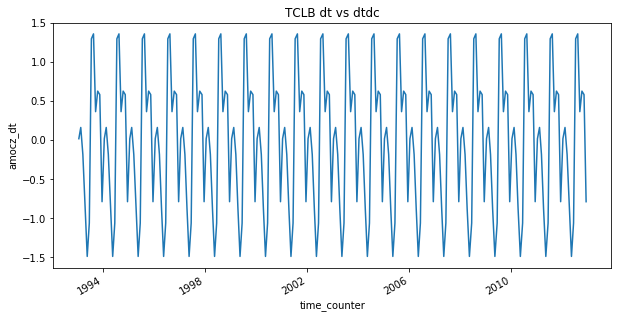

In [60]:
rapidmb1 = amoc.sel(nav_lat=26.,method='nearest',e=10)
rapidmb2 = amoc_acrm.sel(nav_lat=26.,method='nearest',e=10) 
rapidmb3 = rapidmb1-rapidmb2

# plot timeseries
fig1 = plt.figure(figsize=([10,5]),facecolor='white')  
#rapidmb1.plot()
#rapidmb2.plot()
rapidmb3.plot()
plt.title('TCLB dt vs dtdc')

In [61]:

# change dims order so that it is the same as the non-detrended dataset
amoc_dt1 = amoc_acrm.transpose('time_counter','e','nav_lat')

# redefine coordinate
amoc_dt1_def =  xr.DataArray(amoc_dt1.values, dims=('time_counter', 'e','nav_lat'),coords={'time_counter':amoc.time_counter,'e': amoc.e, 'nav_lat': amoc.nav_lat})

# output
outfi = diri+'AMOCZ.MAX.NATL025-GSL301.1993-2012.1m_dtdc.nc'
amoc_dt1_def.name='amocz_dtdc'
amoc_dt1_def.attrs['long_name'] =  "detrended amoc (lowess) and annual cycl removed"
amoc_dt1_def.to_netcdf(outfi,mode='w')



In [55]:
# READ
amoc = amoc_dtREAD2

# clim over 1 year
clim = amoc.groupby('time_counter.month').mean(dim='time_counter')

# rolling mean to smooth out the raw clim a little bit
#clim = clim.rolling(month=3,min_periods=1).mean()

# remove clim to data
amoc_acrm = amoc.groupby('time_counter.month')-clim

In [57]:

# change dims order so that it is the same as the non-detrended dataset
amoc_dt1 = amoc_acrm.transpose('time_counter','e','nav_lat')

# redefine coordinate
amoc_dt1_def =  xr.DataArray(amoc_dt1.values, dims=('time_counter', 'e','nav_lat'),coords={'time_counter':amoc.time_counter,'e': amoc.e, 'nav_lat': amoc.nav_lat})

# output
outfi = diri+'AMOCZ.MAX.NATL025-TCLB300.1994-2012.1m_dtdc.nc'
amoc_dt1_def.name='amocz_dtdc'
amoc_dt1_def.attrs['long_name'] =  "detrended amoc (lowess) and annual cycl removed"
amoc_dt1_def.to_netcdf(outfi,mode='w')



In [38]:
## READ
amoc_dtdcREAD = xr.open_dataset(diro+'AMOCZ.MAX.NATL025-GSL301.1993-2012.1m.nc_dtdc.nc')['amocz_dtdc']
amoc_dtdcREAD2 = xr.open_dataset(diro+'AMOCZ.MAX.NATL025-TCLB300.1994-2012.1m.nc_dtdc.nc')['amocz_dtdc']


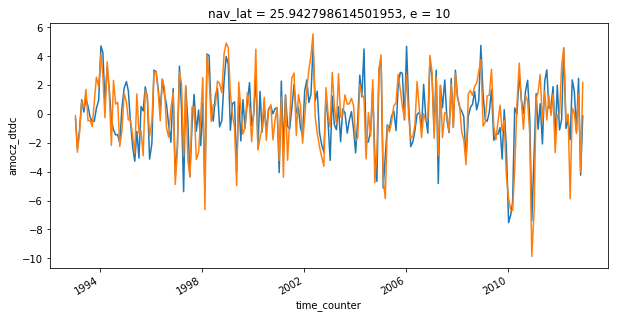

In [39]:
rapidmb1 = amoc_dtdcREAD.sel(nav_lat=26.,method='nearest',e=1)
rapidmb2 = amoc_dtdcREAD.sel(nav_lat=26.,method='nearest',e=10)

# plot timeseries
fig1 = plt.figure(figsize=([10,5]),facecolor='white')  
rapidmb1.plot()
rapidmb2.plot()

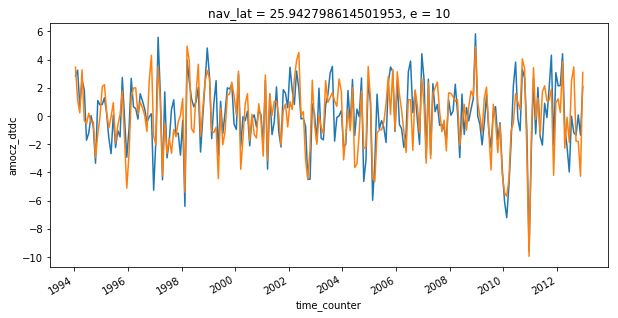

In [40]:
rapidmb1 = amoc_dtdcREAD2.sel(nav_lat=26.,method='nearest',e=1)
rapidmb2 = amoc_dtdcREAD2.sel(nav_lat=26.,method='nearest',e=10)

# plot timeseries
fig1 = plt.figure(figsize=([10,5]),facecolor='white')  
rapidmb1.plot()
rapidmb2.plot()

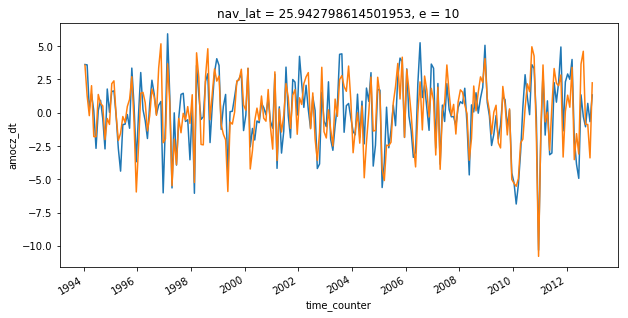

In [41]:
rapidmb1 = amoc_dtREAD2.sel(nav_lat=26.,method='nearest',e=1)
rapidmb2 = amoc_dtREAD2.sel(nav_lat=26.,method='nearest',e=10)

# plot timeseries
fig1 = plt.figure(figsize=([10,5]),facecolor='white')  
rapidmb1.plot()
rapidmb2.plot()

# resample to annual means

In [ ]:
amocGSL
amocTCLB

In [42]:
amocTCLB_A = amocTCLB.resample(time_counter='1Y').mean(dim='time_counter')

In [43]:
amocGSL_A = amocGSL.resample(time_counter='1Y').mean(dim='time_counter')

In [44]:
dataprint_tclb = xr.DataArray(amocTCLB_A.values, dims=('time_counter', 'e','nav_lat'),coords={'time_counter':amocTCLB_A.time_counter,'e': np.arange(1,11), 'nav_lat': amocTCLB_A.nav_lat.squeeze().values})
dataprint_gsl  = xr.DataArray(amocGSL_A.values, dims=('time_counter', 'e','nav_lat'),coords={'time_counter':amocGSL_A.time_counter,'e': np.arange(1,51), 'nav_lat': amocGSL_A.nav_lat.squeeze().values})

In [45]:
diro=diri
outfigsl = diro+'AMOCZ.MAX.NATL025-GSL301.1993-2012.A.nc'
outfitclb = diro+'AMOCZ.MAX.NATL025-TCLB300.1994-2012.A.nc'

dataprint_gsl.name = 'amocz'
dataprint_gsl.attrs['long_name'] =  "amoc_max_z"
dataprint_gsl.to_netcdf(outfigsl,mode='w')

dataprint_tclb.name = 'amocz'
dataprint_tclb.attrs['long_name'] =  "amoc_max_z"
dataprint_tclb.to_netcdf(outfitclb,mode='w')


In [46]:
amoc = amocGSL_A
jd = range(0,amoc.time_counter.size)
il=1
ie=1

for ie in range(0,50):
    
    for il in np.arange(0,amoc.nav_lat.size):  
        # timeseries with time-mean removed
        ts   = amoc.isel(nav_lat=il,e=ie).values
            
        # apply detrending
        ts_tr=getspline(ts,jd)[0]
        ts_dt = ts - ts_tr
     
        tmp = xr.DataArray(ts_dt, dims=('time_counter'),coords={'time_counter':amoc.time_counter})
        if (il!=0):
            concamoc = xr.concat([concamoc,tmp], dim='nav_lat')
        else:
            concamoc = tmp
    if (ie!=0):
        concconcamoc = xr.concat([concconcamoc,concamoc], dim='e')
    else:
        concconcamoc = concamoc
        
# make sure the time mean is exactly zero
concconcamoc = concconcamoc - concconcamoc.mean(dim='time_counter')

In [47]:
diro=diri
# change dims order so that it is the same as the non-detrended dataset
amoc_dt1 = concconcamoc.transpose('time_counter','e','nav_lat')

# redefine coordinate
amoc_dt1_def =  xr.DataArray(amoc_dt1.values, dims=('time_counter', 'e','nav_lat'),coords={'time_counter':amoc.time_counter,'e': amoc.e, 'nav_lat': amoc.nav_lat})

# output
outfi = diro+'AMOCZ.MAX.NATL025-GSL301.1993-2012.A_dt.nc'
amoc_dt1_def.name='amocz_dt'
amoc_dt1_def.attrs['long_name'] =  "detrended amoc z (lowess)"
amoc_dt1_def.to_netcdf(outfi,mode='w')

In [48]:
amoc = amocTCLB_A
jd = range(0,amoc.time_counter.size)
il=1
ie=1

for ie in range(0,10):
    
    for il in np.arange(0,amoc.nav_lat.size):  
        # timeseries with time-mean removed
        ts   = amoc.isel(nav_lat=il,e=ie).values
            
        # apply detrending
        ts_tr=getspline(ts,jd)[0]
        ts_dt = ts - ts_tr
     
        tmp = xr.DataArray(ts_dt, dims=('time_counter'),coords={'time_counter':amoc.time_counter})
        if (il!=0):
            concamoc = xr.concat([concamoc,tmp], dim='nav_lat')
        else:
            concamoc = tmp
    if (ie!=0):
        concconcamoc = xr.concat([concconcamoc,concamoc], dim='e')
    else:
        concconcamoc = concamoc
        
# make sure the time mean is exactly zero
concconcamoc = concconcamoc - concconcamoc.mean(dim='time_counter')

In [49]:
diro=diri
# change dims order so that it is the same as the non-detrended dataset
amoc_dt1 = concconcamoc.transpose('time_counter','e','nav_lat')

# redefine coordinate
amoc_dt1_def =  xr.DataArray(amoc_dt1.values, dims=('time_counter', 'e','nav_lat'),coords={'time_counter':amoc.time_counter,'e': amoc.e, 'nav_lat': amoc.nav_lat})

# output
outfi = diro+'AMOCZ.MAX.NATL025-TCLB300.1994-2012.A_dt.nc'
amoc_dt1_def.name='amocz_dt'
amoc_dt1_def.attrs['long_name'] =  "detrended amoc z (lowess)"
amoc_dt1_def.to_netcdf(outfi,mode='w')